In this research we are are interested in structural breaks of the SP500. A structural break is an abrupt shift in the behaviour of a time series. As defined on wikipedia, "a structural break is an unexpected change over time in the parameters of regression models, which can lead to huge forecasting errors and unreliability of the model in general"[1]. 

We will investigate this concept using the SP500 market index from 1812 to 2018

First let's download the data set and make a preliminary analysis of the task at hand. 


[1] https://en.wikipedia.org/wiki/Structural_break

Import Libraries

In [6]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Import dataset and compute returns, absolute returns, cumulative returns, difference ($y_t$ - $y_{t-1}$)

In [15]:
df_data_raw = pd.read_excel('D:\\Finance_Project\\Data_SP500\\Raw_Data.xlsx', usecols=['Actual Date', 'SP500'])
df_data_raw.rename(columns={'Actual Date': 'Date'}, inplace=True)

df_data_raw.Date = pd.to_datetime(df_data_raw.Date, infer_datetime_format='YYYY-MM-DD') # cast string to datetime object
df_data_raw.set_index('Date', inplace=True) # set index as date

df_data = df_data_raw.copy()

# calculate returns
df_data['returns'] = df_data['SP500'].pct_change()

# drop rows with nan value in any columns
df_data.dropna(axis='rows', inplace=True)

# compute absolute returns
df_data['abs_returns'] = df_data['returns'].abs()

# calculate difference with lag 1
df_data['delta'] = df_data['SP500'].diff(1)

# compute cumulative returns
df_data['cum_returns'] = df_data['returns'].cumsum()

print('DataFrame To Analyse')
print(df_data.describe())


DataFrame To Analyse
             SP500      returns  abs_returns        delta  cum_returns
count  2473.000000  2473.000000  2473.000000  2472.000000  2473.000000
mean    182.931312     0.006279     0.032917     1.068310     7.372050
std     448.978761     0.046557     0.033512    18.061567     4.621532
min       0.007246    -0.299423     0.000000  -197.610000     0.000347
25%       0.132439    -0.016300     0.010417    -0.016334     3.392616
50%       3.849148     0.006077     0.024278     0.000518     7.252364
75%      84.210000     0.031397     0.044532     0.243049    11.509467
max    2823.810000     0.391376     0.391376   159.330000    15.593377


Our data set is composed of 2473 observations. It made of the closing value of the last day of the month from 1812 to 2018. 

Let $X_t$ = {$x_1$, $x_2$,..., $x_n$}
where n = 2473 and $X_t$ is the value of the SP500 at time t (1 < t < n)

Text(0, 0.5, 'Value')

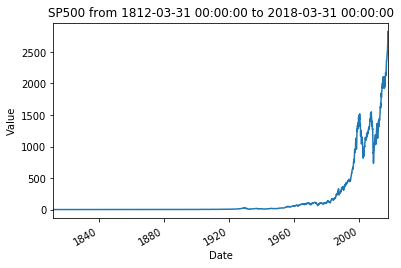

In [25]:
df_data.SP500.plot()
plt.title('SP500 from ' + str(df_data.index.min()) + " to " + str(df_data.index.max()))
plt.ylabel("Value")

At first glance, we see an exponentially increasing process with two major drops in value. 

No suprises here. Because of compounded interest, we expected to see an exponentially increasing process. 
As we know, markets crash sometimes. The two major drops appear to be the crash of 2000 and 2008, but we will investigate more later on. 

For now we need to fix an issue. The SP500 has a value of around 2700 points nowadays, but it used to be much lower. We can see above that minimum value is 0.007246 and the maximum 2823.81. So the immense value of the SP compared to it's early days hides the early behaviours of the serie.

To fix that we can use the natural log transform of the original value.

Let $Y_t = ln(X_t)$

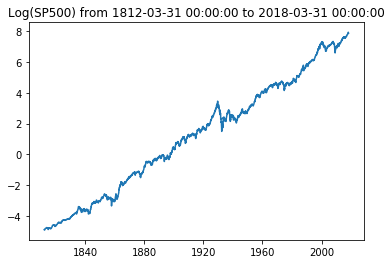

In [39]:
log_value = np.log(df_data.SP500)
plt.plot(log_value)
plt.title('Log(SP500) from ' + str(df_data.index.min()) + " to " + str(df_data.index.max()))
plt.show()

We now see the full behavior of the serie. 
The natural log function linearizes exponential functions. That is why we are seeing somewhat of a straight line. 
Also, for small values (smaller then 1) the log function outputs negative values. 

We can still see the drops from earlier but they are now more subtle. What is less subtle than before is the crash of 1929 which appears to be the biggest drawdown of the serie. We will confirm this hypothesis


An other way to analyse market index or stock price time series is to look at the returns, so let's see what we have!



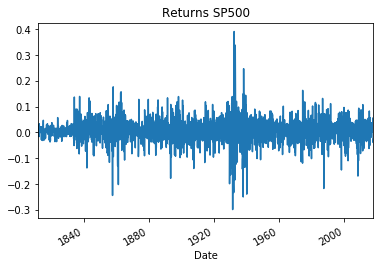

In [19]:
df_data.returns.plot()
plt.title('Returns SP500')
plt.show()

We can see that the returns fluctuate around zero with extreme values going from -30% to approximately 40%.Let's plot the distribution of returns and a box plot to be sure

(Side note to investigate later with models: a bit before 1840, the returns seems to shift "speed" i.e. the fluctuations are smaller before 1840.) 

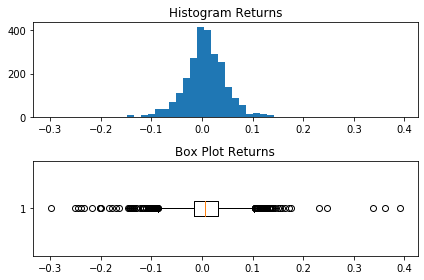

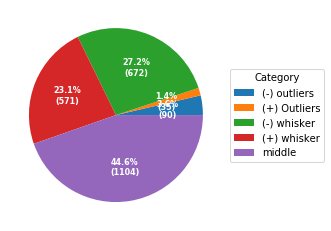

In [102]:
fig, axes = plt.subplots(2,1)

# plot histogram
freq, bins, _ = axes[0].hist(df_data.returns, bins=50)
axes[0].set_title('Histogram Returns')
# plot box plot
box = axes[1].boxplot(df_data.returns, vert=False)
axes[1].set_title('Box Plot Returns')
fig.tight_layout()
plt.show()

# plot pie chart
df_histo = pd.DataFrame({'Frequency':freq}, index=bins[0:50])

median = np.median(df_data.returns)
upper_quartile = np.percentile(df_data.returns, 75)
lower_quartile = np.percentile(df_data.returns, 25)

iqr = upper_quartile - lower_quartile
upper_whisker = df_data.returns[df_data.returns<=upper_quartile+1.5*iqr].max()
lower_whisker = df_data.returns[df_data.returns>=lower_quartile-1.5*iqr].min()

nb_neg_outliers = df_histo.loc[df_histo.index < lower_whisker].sum()
nb_pos_outliers = df_histo.loc[df_histo.index > upper_whisker].sum()
nb_neg_whisker = df_histo.loc[(df_histo.index > lower_whisker) & (df_histo.index < lower_quartile)].sum()
nb_pos_whisker = df_histo.loc[(df_histo.index < upper_whisker) & (df_histo.index > upper_quartile)].sum()
nb_middle = df_histo.loc[(df_histo.index < upper_quartile) & (df_histo.index > lower_quartile)].sum()
list_pie_chart = [nb_neg_outliers[0], nb_pos_outliers[0], nb_neg_whisker[0], nb_pos_whisker[0], nb_middle[0]]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

labels=['(-) outliers', '(+) Outliers', '(-) whisker', '(+) whisker', 'middle']
wedges, texts, autotexts = plt.pie(list_pie_chart,
                                   autopct=lambda pct: func(pct, list_pie_chart), textprops=dict(color="w"))
plt.legend(wedges, labels,
          title="Category",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
plt.show()


So we can see from the histogram and box plot that most returns are around zero. The distribution seems to be symmetric around zero. The high density around the mean and the presence of extreme values at the tails indicates returns might have a distribution with heavy tail, possibly a power law distribution. 

Power law distributions are of the form $p(x) \propto x^{-\alpha}$. 
Or $p(x; \alpha, x_{min}) = \frac{\alpha-1}{x_{min}} \dot (\frac{x}{x_{min}})^{-\alpha}$.

We test this hypothesis with the help of the power law package

Calculating best minimal value for power law fit


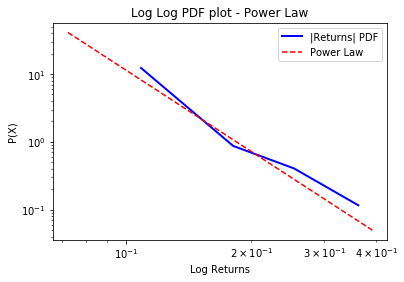

Alpha: 3.981371764671092 Sigma: 0.1932536279153089
Min selected: 0.07245898004188578 Max Selected: None
Minimum K-S distance D: 0.029128968592549348


In [114]:
import powerlaw

# Power Law Distribution Testing
temp_returns = df_data.abs_returns.copy() # take the absolute returns to avoid warning when fitting data to power law
temp_returns.iloc[temp_returns.values == 0] = np.nan # replace 0 values with Nan (powerlaw is undefined for x = 0)
temp_returns.dropna(inplace=True) # Drop NaNs
arr_returns = temp_returns.to_numpy() # cast to numpy array

fit = powerlaw.Fit(arr_returns) # fit data to power law
alpha = fit.alpha  # power coefficient
sigma = fit.sigma  # std. error
x_min = fit.xmin
x_max = fit.xmax
distance = fit.D

fig2 = fit.plot_pdf(color='b', linewidth=2, label='|Returns| PDF')  # plot pdf of SP500
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig2, label='Power Law') # plot power law 
plt.title('Log Log PDF plot - Power Law')
plt.xlabel('|Returns|')
plt.ylabel('P(X)')
plt.legend(loc='best')
plt.show()

print('Alpha: ' + str(alpha) + " Sigma: " + str(sigma))
print("Min selected: " + str(x_min) + " Max Selected: " + str(x_max))
print('Minimum K-S distance D: ' + str(distance))

Our test reveals that our data might have $\alpha = 3.98137$ with a standard error $\sigma = 0.19$.

To estimate these parameters the power law package first finds the a minimal x value, in this case $x_{min} =  0.07245898$. It finds the minimal value "by creating a power law fit starting from each value in the dataset, then selecting the one that as the minimal Kolmogorov-Smirov distance, D, between the data and the fit"[2]. In our context a upper-bound is not needed. It then uses the $x_{min}$ value to compute the maximum likehood of the parameter $\alpha$ with the following estimator: $\hat{\alpha} = 1 + n \dot (\sum_{i=1}^{n} \ln{\frac{x_i}{x_{min}}})^{-1}$

The graph shows in blue the probability density function of our data set and in red the theoritical power law pdf. We see that it doesn't fit perfectly but it is close. The returns from 10% to 20% seems to follow the theoritical power law distribution. But for returns greater than that, the pdf curve is diverging from the theoritical pdf. These returns are what we identified earlier as outliers. 


[2]arXiv:1305.0215v3 [physics.data-an] 31 Jan 2014.  J. Alstott, Ed Bullmore, D. Plenz1. "powerlaw: a Python package for analysis of heavy-tailed distributions"

We will now compare our data power law fit against other likely distributions

In [112]:

ditributions_to_test = fit.supported_distributions

if 'power_law' in ditributions_to_test:
    ditributions_to_test.pop('power_law')
for key, value in ditributions_to_test.items():
    distribution_test = key
    p_best = .5
    R_best = 1
    R, p = fit.distribution_compare('power_law', distribution_test, normalized_ratio=True)
    print('Distribution '+str(distribution_test)+ "\nR: " + str(R) + " P-value: " + str(p))




Distribution lognormal
R: -0.3639812448423289 P-value: 0.7158720146391222
Distribution exponential
R: 1.8678980905652804 P-value: 0.06177627709835416
Distribution truncated_power_law
R: -0.5544161692525823 P-value: 0.4576974070073856
Distribution stretched_exponential
R: -0.06246360830825343 P-value: 0.9501936416871304
Distribution lognormal_positive
R: 8499.679459911678 P-value: 0.0


Assuming nested distributions


TODO: confirm results with Calin

If the R value is positive, it means the most likely distribution is the power_law, else it is the other one.
The only significant P-value are with the distributions exponential and lognormal_positive. In both cases the power law distribution is more likely.

Our previous plot showed that the returns were close of being exponentially distributed. We now compare the Complementary Cumulative Distribution Function (CCDF) which is $P(X \geq x)$



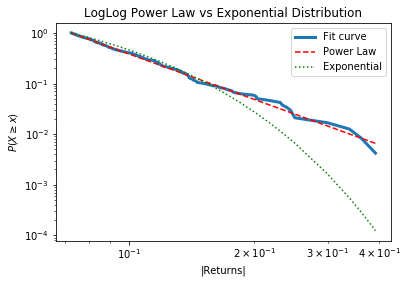

In [118]:
fit.distribution_compare('power_law', 'exponential')
fig4 = fit.plot_ccdf(linewidth=3, label='Fit curve')
fit.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--', label='Power Law')
fit.exponential.plot_ccdf(ax=fig4, color='g', linestyle=':', label='Exponential')
plt.title('LogLog Power Law vs Exponential Distribution')
plt.legend(loc='best')
plt.xlabel('|Returns|')
plt.ylabel('$P(X \geq x)$')
plt.show()


By now we have done many thing, hence we are due for a little recap. 

We have downloaded and visualize the data set. At first we couldn't see much because of the nature of our data set. So we used a log transformation so we could visualize our entire data set. Not only were we able to see more clearly the data, but we also have more evidence that the value of the SP500 follow an exponential increase since it appears almost as a straight line when we apply the log transform. 

We then moved on to study a bit abount the returns. We tested and confirmed our hypothesis that returns follow a power law distribution with alpha of 3.9 

Now, let's come back to our main purpose, structural breaks. 

So a structural break is an unexpected change overtime in parameters of a regression model as we defined it above.
If we want to identify structural breaks in the SP500 data, we will first need to find the model that best fits our time series and then run a regression to idenfity the dates where it fails. 

Potential candidates of models are infinite, but we will restrict our selve to a handfull and see the results. 

For the rest of this article, we will briefly explain different models, illustrate each of them with a synthetic dataset and run a regression to test it power. We will then test the each model on our dataset and see the best model for us. 

Once a model is chosen, we will be able to identify where and how it breaks on our data set.

We first create a function that allows us to visualize a time series, acf and pacf plot, QQ plot and probability plot. 


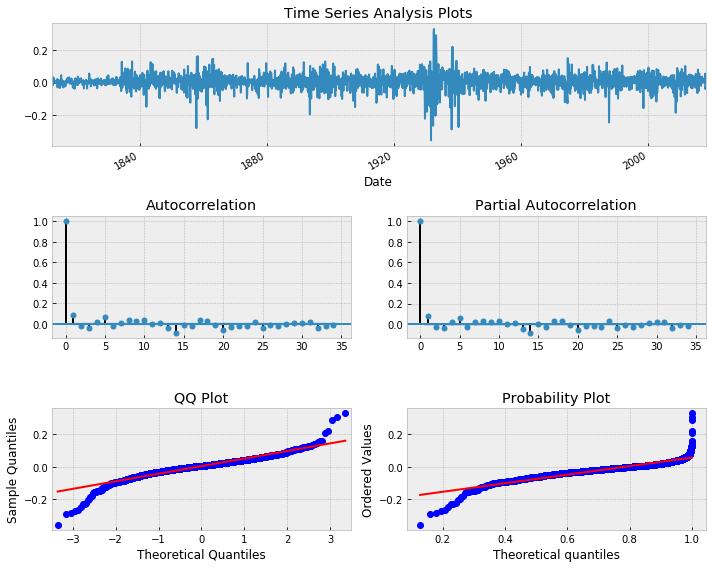

In [132]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        # mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
        plt.show()
    return

log_returns = np.log(df_data.SP500/df_data.SP500.shift(1)).dropna()
tsplot(log_returns)

<h1> Random Walk Process

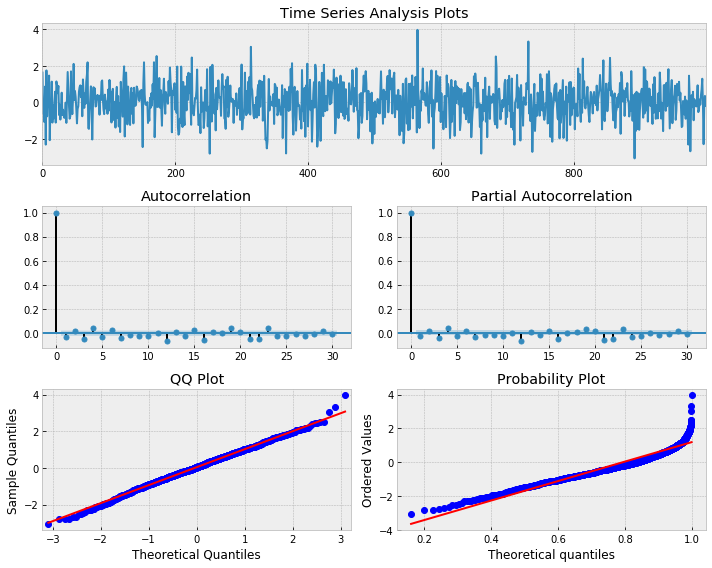

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


In [134]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)
print("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
      .format(randser.mean(), randser.var(), randser.std()))

<h1> Random Walk with Drift

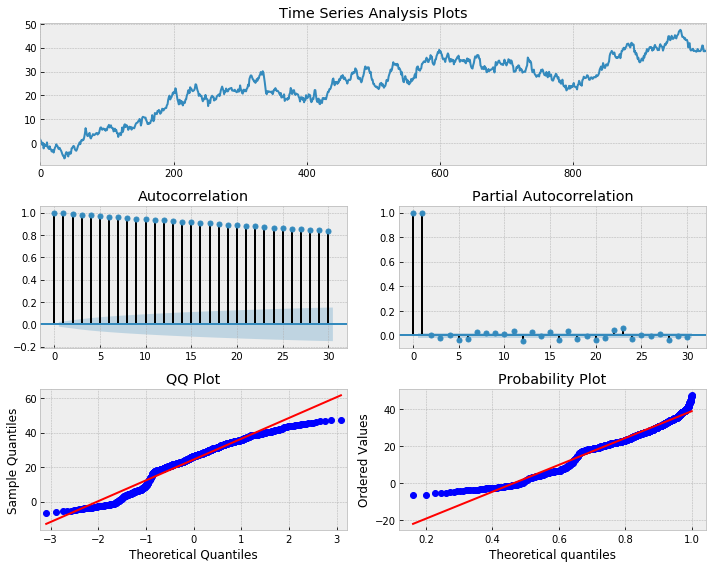

In [135]:
np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

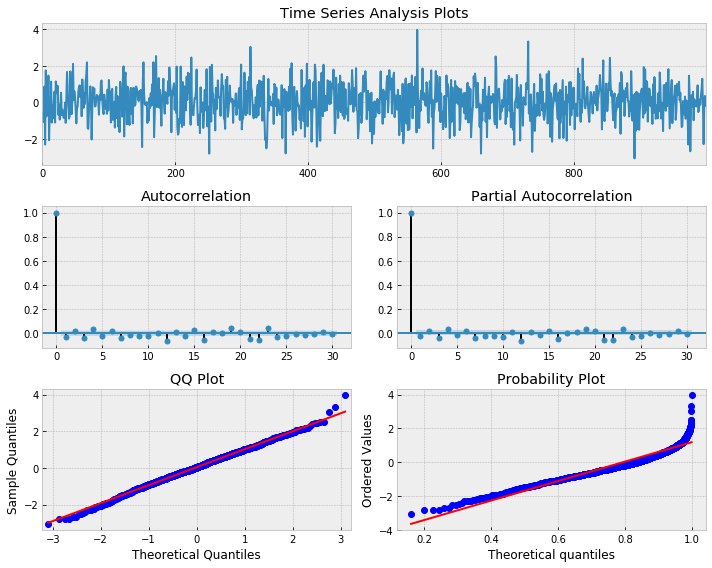

In [136]:
# First difference of simulated Random Walk series

_ = tsplot(np.diff(x), lags=30)


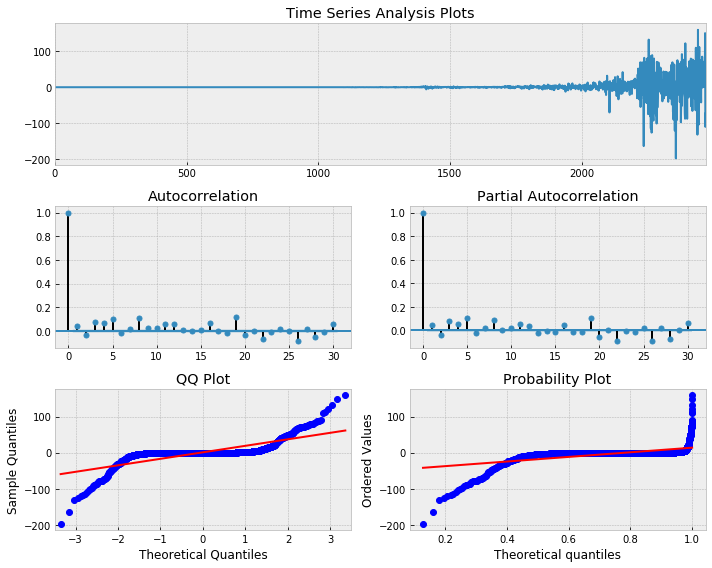

In [137]:
# First difference of SP500 values
_ = tsplot(np.diff(df_data.SP500), lags=30)


THE FOLLOWING CODE IS STILL WIP 
for the final paper the code will be broken down in segments and interpreted with the rest of the results. 

In [ ]:
#%%
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import plotly
import plotly.subplots as sb
import plotly.graph_objects as go
import plotly.express as px
from sklearn import metrics
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib as mpl
# import data from other scripts
from time_serie_analysis import *
from preprocessing_data import *

#%%

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        # mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
        plt.show()
    return

log_returns = np.log(df_data.SP500/df_data.SP500.shift(1)).dropna()
# log_returns = log_returns.replace(np.inf, np.nan)
# log_returns.dropna(inplace=True)
tsplot(log_returns)

#%%
# AR Model
# synthetic
lags=30
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a * x[t - 1] + w[t]

_ = tsplot(x, lags=lags)

# fit synthetic
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'
  .format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))
#%%
max_lag = 30
mdl = smt.AR(log_returns).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(log_returns).select_order(maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = {}'.format(est_order))

#%%
# Moving Average Model
# synthetic
n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma1, lags=30)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

#%%
# ARMA on SP500
max_lag = 30
Y = log_returns
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

#%%
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())
#%%
# FIt ARMA to SP500
#

best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(log_returns, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: -8143.85952 | order: (4, 4)

# plot residuals
_ = tsplot(best_mdl.resid)

#%%
# Fit ARIMA(p, d, q) model to SP500 Returns
# pick best order and final model based on aic

best_aic = np.inf
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(log_returns, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)
#%%
# Synthetic ARCH Model
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

#%%
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)
#%%
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())
#%%

def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl
"""
    Iterate through combinations of ARIMA(p, d, q) models to best fit our time series.

    Pick the GARCH model orders according to the ARIMA model with lowest AIC.

    Fit the GARCH(p, q) model to our time series.

    Examine the model residuals and squared residuals for autocorrelation
"""
# Notice I've selected a specific time period to run this analysis
TS = log_returns
res_tup = _get_best_model(TS)
#%%
_ = tsplot(best_mdl.resid**2)

# aic: -8143.85952 | order: (4, 0, 4)

#%%
# Fit GARCH MODEL with best order arima
# Now we can fit the arch model using the best fit arima model parameters

p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS*10, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())
tsplot(res.resid)



In [ ]:
def findpeaks(series, DELTA):

    # Set inital values
    mn, mx = np.Inf, -np.Inf
    minpeaks = []
    maxpeaks = []
    lookformax = True
    start = True
    # Iterate over items in series
    for time_pos, value in series.iteritems():
        if value > mx:
            mx = value
            mxpos = time_pos
        if value < mn:
            mn = value
            mnpos = time_pos
        if lookformax:
            if value < mx-DELTA:
                # a local maxima
                maxpeaks.append((mxpos, mx))
                mn = value
                mnpos = time_pos
                lookformax = False
            elif start:
                # a local minima at beginning
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                start = False
        else:
            if value > mn+DELTA:
                # a local minima
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                lookformax = True
    # check for extrema at end
    if value > mn+DELTA:
        maxpeaks.append((mxpos, mx))
    elif value < mx-DELTA:
        minpeaks.append((mnpos, mn))
    return minpeaks, maxpeaks

# findpeaks(log_price, 4)
# series = log_price
series = df_data.returns
minpeaks, maxpeaks = findpeaks(series, DELTA=0.5)
# Plotting the figure and extremum points
fig, ax = plt.subplots()
ax.set_ylabel('SP500 Log Price')
ax.set_xlabel('Time')
ax.set_title('Peaks in TimeSeries')
series.plot()
ax.scatter(*zip(*minpeaks), color='red', label='min')
ax.scatter(*zip(*maxpeaks), color='green', label='max')
ax.legend()
ax.grid(True)

plt.show()


      Slope  Intercept   R-Value   P-Value  Std Error  Fractal Dimension  \
0  0.946420  -0.283539  0.997897  0.000007   0.030738           1.053580   
1  1.011679  -0.432999  0.999968  0.005085   0.008081           0.988321   
2  0.723252   0.425456  1.000000  0.000000   0.000000           1.276748   
3  1.025763  -0.461052  1.000000  0.000000   0.000000           0.974237   
4  1.069757  -0.579083  1.000000  0.000000   0.000000           0.930243   
5  0.723252   0.425456  1.000000  0.000000   0.000000           1.276748   

    Time Period  
0   Full Series  
1    First Half  
2   Second Half  
3   First Third  
4  Second Third  
5   Third Third  


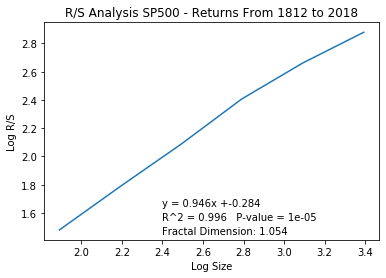

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress


# ---------------------------- Hurst Coefficient Computation
def compute_hurst(series_ts, power):

    ts_price = series_ts
    list_subseries = []
    # split time series into power of 2 (i.e.: first subset length is 2473, 2473/2....
    for i in np.arange(0, power):

        n = len(ts_price)
        ts_temp = ts_price.copy()
        partition_size = 2 ** i
        ts_partitioned = np.array_split(ts_temp, partition_size)
        list_subseries.append(ts_partitioned)

    list_sublist_name = []
    list_sublist_rs = []
    list_sublist_size = []

    for j in np.arange(len(list_subseries)):

        list_sublist_name.append(len(list_subseries[j]))
        list_temp_rs = []
        for k in np.arange(len(list_subseries[j])):
            sub_list = list_subseries[j][k]

            if k == 0:
                list_sublist_size.append(len(sub_list))

            m_j = np.mean(sub_list)  # compute mean
            s_j = np.sqrt(np.var(sub_list))  # compute std dev
            ts_adjusted = sub_list - m_j  # compute adjusted series
            ts_run_total = np.cumsum(ts_adjusted)  # compute runnig sum of adjusted serie
            run_max = np.max(ts_run_total)
            run_min = np.min(ts_run_total)
            run_range = run_max - run_min
            r_s = run_range / s_j
            list_temp_rs.append(r_s)

        list_sublist_rs.append(np.mean(list_temp_rs))

    df_rs = pd.DataFrame({'Range': list_sublist_name, 'Size':list_sublist_size, 'AVG_RS': list_sublist_rs})

    df_rs['Log_Size'] = np.log10(df_rs.Size)
    df_rs['Log_AVG_RS'] = np.log10(df_rs.AVG_RS)

    return df_rs


# -- Compute Hurst with returns
# df_results = compute_hurst(series_ts=df_data.returns, power=6)
df_results = compute_hurst(series_ts=df_data.SP500, power=6)

df_results_h1 = df_results.iloc[3:]
df_results_h2 = df_results.iloc[0:2]

df_results_t1 = df_results.iloc[4:6]
df_results_t2 = df_results.iloc[2:4]
df_results_t3 = df_results.iloc[0:2]

list_hurst_results = [df_results, df_results_h1, df_results_h2, df_results_t1, df_results_t2, df_results_t3]
list_name_results = ['Full Series', 'First Half', 'Second Half', 'First Third', 'Second Third', 'Third Third']
list_dict_result = []
for i in np.arange(len(list_hurst_results)):
    temp = list_hurst_results[i]
    slope, intercept, r_value, p_value, std_err = linregress(temp['Log_Size'], temp['Log_AVG_RS'])
    dict_results = {'Slope': slope, 'Intercept': intercept, 'R-Value': r_value, 'P-Value': p_value, 'Std Error': std_err
                    , 'Fractal Dimension': (2-slope), 'Time Period': list_name_results[i]}
    list_dict_result.append(dict_results)

df_table_all_results = pd.DataFrame(list_dict_result)
print(df_table_all_results.head(6))

slope, intercept, r_value, p_value, std_err = linregress(df_results['Log_Size'], df_results['Log_AVG_RS'])

plt.plot(df_results['Log_Size'], df_results['Log_AVG_RS'])
plt.ylabel('Log R/S')
plt.xlabel('Log Size')
plt.title('R/S Analysis SP500 - Returns From 1812 to 2018')
plt.text(2.4, 1.65, 'y = ' + str(round(slope, 3)) + 'x +' + str(round(intercept, 3)))
plt.text(2.4, 1.55, 'R^2 = ' + str(round(r_value ** 2, 3)) + '   P-value = ' + str(round(p_value, 5)))
plt.text(2.4, 1.45, 'Fractal Dimension: ' + str(round(2-slope, 3)))
plt.show()

# ---- Compute hurst with Log returns

# temp_ts = df_data['returns'].replace(0, 1)
# temp_ts = temp_ts.apply(lambda x: np.log10(x))
# temp_ts.dropna(axis='rows', inplace=True)
# df_results_1 = compute_hurst(series_ts=temp_ts, power=6)
# 
# slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = linregress(df_results_1['Log_Size'], df_results_1['Log_AVG_RS'])
# plt.clf()
# plt.plot(df_results_1['Log_Size'], df_results_1['Log_AVG_RS'])
# plt.ylabel('Log R/S')
# plt.xlabel('Log Size')
# plt.title('R/S Analysis SP500 Log Returns - 1812 to 2018')
# plt.text(1.8, 1.6, 'y = ' + str(round(slope_1, 3)) + 'x +' + str(round(intercept_1, 3)))
# plt.text(1.8, 1.55, 'R^2 = ' + str(round(r_value_1 ** 2, 3)) + '   P-value = ' + str(round(p_value_1, 5)))
# plt.text(1.8, 1.5, 'Fractal Dimension: ' + str(round(2-slope_1, 3)))
# plt.show()
